In [6]:
import pickle
import numpy as np
import pandas as pd
import cv2 
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from __future__ import print_function
import os
# import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.models as models
from torchvision import datasets, transforms
from sklearn.utils import resample
import matplotlib.pyplot as plt

# Preprocessing and Loading the WM811K Dataset
def load_wm811k_data(path_to_dataset):
    """
    Load and preprocess the WM811K dataset.

    Parameters:
        path_to_dataset (str): Path to the WM811K .pkl dataset.

    Returns:
        tuple: Preprocessed data and labels.
    """
    # Load dataset and drop unnecessary columns
    df = pd.read_pickle(path_to_dataset)
    df = df.drop(['waferIndex'], axis=1)
    df['waferMapDim'] = df['waferMap'].apply(lambda x: (np.size(x, axis=0), np.size(x, axis=1)))
    df['failureNum'] = df['failureType']

    # Map failure types to numerical values
    mapping_type = {
        'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3,
        'Loc': 4, 'Random': 5, 'Scratch': 6, 'Near-full': 7, 'none': 8
    }
    df = df.replace({'failureNum': mapping_type})

    # Select wafers with valid patterns
    df_withpattern = df[(df['failureNum'] >= 0)].reset_index()

    wafer_maps = df_withpattern['waferMap'].to_numpy()
    labels = df_withpattern['failureNum'].to_numpy()

    # Resize images to (32, 32) while preserving aspect ratio and normalize
    data = []
    for wafer_map in wafer_maps:
        # Convert to float32 if not already
        image = np.array(wafer_map, dtype=np.float32)

        # Apply morphological closing
        #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))  # You can adjust the kernel size as needed
        #closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)


        # Get original dimensions
        original_height, original_width = image.shape

        # Calculate scaling factor to fit within 32x32
        scaling_factor = min(32 / original_width, 32 / original_height)
        new_width = int(original_width * scaling_factor)
        new_height = int(original_height * scaling_factor)

        # Resize image to new dimensions
        resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)  #Use cv2.INTER_CUBIC for upscaling and cv2.INTER_AREA for downscaling to preserve image quality:

        # Create a blank 32x32 canvas and center the resized image
        padded_image = np.full((32, 32), 0, dtype=np.float32)  # Black background
        x_offset = (32 - new_width) // 2
        y_offset = (32 - new_height) // 2
        padded_image[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_image

        # Append the padded and resized image
        data.append(padded_image)

    data = np.expand_dims(data, axis=1)  # Adding channel dimension for PyTorch
    data = np.array(data)

    # Oversampling to balance the dataset
    combined = [(x, y) for x, y in zip(data, labels)]
    class_samples = {cls: [sample for sample in combined if sample[1] == cls] for cls in np.unique(labels)}
    max_class_size = max(len(samples) for samples in class_samples.values())
    
    oversampled_samples = []
    for cls, samples in class_samples.items():
        oversampled_samples.extend(
            resample(samples, replace=True, n_samples=max_class_size, random_state=42)
            )
    np.random.shuffle(oversampled_samples)

    # Split back into data and labels after oversampling
    data = np.array([sample[0] for sample in oversampled_samples])
    labels= np.array([sample[1] for sample in oversampled_samples])

    return data, labels

# Custom Dataset for PyTorch
class WaferMapDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Custom dataset for wafer maps.

        Parameters:
            data (np.ndarray): Preprocessed wafer map images.
            labels (np.ndarray): Corresponding labels.
            transform (callable, optional): Transformations for data augmentation.
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Path to WM811K dataset
path_to_dataset = "C:/Users/Soumya Taneja/Desktop/Sideproject/WM811Kdata/LSWMD.pkl"

# Load and preprocess the data
data, labels = load_wm811k_data(path_to_dataset)

# Define data transformations (if needed)
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization for grayscale images
])

# Create the dataset and dataloader
dataset = WaferMapDataset(data, labels, transform=None)  # Apply transforms if needed
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example: Check a batch of data
for batch_images, batch_labels in dataloader:
    print("Batch images shape:", batch_images.shape)
    print("Batch labels shape:", batch_labels.shape)
    break


Batch images shape: torch.Size([32, 1, 32, 32])
Batch labels shape: torch.Size([32])


In [7]:
class VGG16Classifier(nn.Module):
    def __init__(self, init_weights=True, num_class=10,  feature_dim = 512):
        self.num_class = num_class
        super(VGG16Classifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(feature_dim, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_class),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        loss = 0
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

                
def make_variable(tensor):
    if torch.cuda.is_available():
        tensor = tensor.to('cuda')
    return Variable(tensor)


def load_training(root_path, dir, batch_size, kwargs):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    data = datasets.ImageFolder(root=root_path + dir, transform=transform)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)
    return train_loader

def load_testing(root_path, dir, batch_size, kwargs):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    data = datasets.ImageFolder(root=root_path + dir, transform=transform)
    test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, **kwargs)
    return test_loader

def load_datasets(root_path, src_dataset, tgt_dataset, batch_size):
    no_cuda = False
    os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5"
    cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(8)
    if cuda:
        torch.cuda.manual_seed(8)

    kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

    src_data_loader = load_training(root_path, src_dataset, batch_size, kwargs)
    tgt_data_loader = load_training(root_path, tgt_dataset, batch_size, kwargs)
    tgt_data_test = load_testing(root_path, tgt_dataset, batch_size, kwargs)
    return src_data_loader, tgt_data_loader, tgt_data_test

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

def visualize_dataset_split(data, labels, title="Dataset Split"):
    """
    Visualize the class distribution and random samples from the dataset.

    Parameters:
        data (np.ndarray): Data samples.
        labels (np.ndarray): Corresponding labels.
        title (str): Title for the visualization.
    """
    # Plot class distribution
    class_counts = Counter(labels)
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title(f"Class Distribution: {title}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(range(max(class_counts.keys()) + 1))
    plt.show()

    # Display a few random samples
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    indices = np.random.choice(len(data), size=5, replace=False)
    for i, idx in enumerate(indices):
        axes[i].imshow(data[idx].squeeze(), cmap='gray')
        axes[i].set_title(f"Class: {labels[idx]}")
        axes[i].axis('off')
    plt.suptitle(f"Random Samples: {title}")
    plt.show()


In [9]:
class CDADA(object):

    def __init__(self, pkl_file_path, num_class=8, max_epoch=120, batch_size=32, learning_rate=0.0001 ):
        self.pkl_file_path = pkl_file_path
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.lr = learning_rate
        self.t_correct = 0
        self.updata = 6

        # Load the dataset from the .pkl file
        data, labels = load_wm811k_data(self.pkl_file_path)

        # Split into training and testing datasets
        split_ratio = 0.8
        split_index = int(len(data) * split_ratio)
        src_data, tgt_data = data[:split_index], data[split_index:]
        src_labels, tgt_labels = labels[:split_index], labels[split_index:]

        # Visualize training and testing datasets
        visualize_dataset_split(src_data, src_labels, title="Training Dataset")
        visualize_dataset_split(tgt_data, tgt_labels, title="Testing Dataset")

        self.datasets_source = DataLoader(
            WaferMapDataset(src_data, src_labels),
            batch_size=self.batch_size,
            shuffle=True
        )
        self.dataset_target = DataLoader(
            WaferMapDataset(tgt_data, tgt_labels),
            batch_size=self.batch_size,
            shuffle=True
        )
        self.dataset_target_test = DataLoader(
            WaferMapDataset(tgt_data, tgt_labels),
            batch_size=self.batch_size,
            shuffle=False
        )

        # Load VGG16 model
        model = models.vgg16(pretrained=True)
        model.load_state_dict(torch.load('C:/Users/Soumya Taneja/Desktop/Sideproject/vgg16-397923af.pth'))

        pretrained_weights = model.features[0].weight.mean(dim=1, keepdim=True)
        model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        model.features[0].weight.data = pretrained_weights
        
        for i, para in enumerate(model.features.parameters()):
            if i < 24:
                para.requires_grad = False

        
        self.Generator = model.features
        self.Generator.to('cuda')  # Move the model to GPU

        # Debugging: Check the shape of the output from Generator
        sample_input = torch.randn(1, 1, 32, 32).to('cuda')  # Example input (batch size 1, 1 channel, 32x32)
        sample_output = self.Generator(sample_input)
        #print("Shape of Generator output:", sample_output.shape)
        # Determine feature_dim dynamically
        feature_dim = 512
        self.Classifier = VGG16Classifier(num_class=num_class, feature_dim =feature_dim)
        self.Classifier1 = VGG16Classifier(num_class=num_class, feature_dim =feature_dim)
        self.Classifier2 = VGG16Classifier(num_class=num_class, feature_dim =feature_dim)
       
        self.Generator.to('cuda')
        self.Classifier.to('cuda')
        self.Classifier1.to('cuda')
        self.Classifier2.to('cuda')

        self.opt_generator = optim.Adam(filter(lambda p: p.requires_grad, self.Generator.parameters()),
                                        lr=self.lr, weight_decay=0.0005)
        self.opt_classifier = optim.Adam(self.Classifier.parameters(),
                                         lr=self.lr, weight_decay=0.0005)
        self.opt_classifier1 = optim.Adam(self.Classifier1.parameters(),
                                          lr=self.lr, weight_decay=0.0005)
        self.opt_classifier2 = optim.Adam(self.Classifier2.parameters(),
                                          lr=self.lr, weight_decay=0.0005)
        
        # For tracking learning curve
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def reset_grad(self):
        self.opt_generator.zero_grad()
        self.opt_classifier.zero_grad()
        self.opt_classifier1.zero_grad()
        self.opt_classifier2.zero_grad()

    def test(self):
        self.Generator.eval()
        self.Classifier.eval()
        correct = 0
        size = 0
        val_loss = 0 

        criterion = nn.CrossEntropyLoss().to('cuda')

        with torch.no_grad(): 
            for data, target in self.dataset_target_test:
                img = make_variable(data).to('cuda')
                label = make_variable(target).to('cuda')

                feat = self.Generator(img)
                pred = self.Classifier(feat)

                loss = criterion(pred, label)
                val_loss += loss.item()

                pred = pred.argmax(dim=1)  #pred = pred.data.max(1)[1]
                k = label.data.size()[0]
                correct += pred.eq(label).sum().item()
                size += k

        val_accuracy = 100.0 * correct / size
        val_loss = val_loss / len(self.dataset_target_test)

        # Track validation loss and accuracy
        self.val_losses.append(val_loss)
        self.val_accuracies.append(val_accuracy)

        if correct > self.t_correct:
            self.t_correct = correct

        print('Accuracy: {}/{} ({:.2f}%) Max Accuracy: {}/{} ({:.2f}%) \n'.
              format(correct, size, 100. * correct / size, self.t_correct, size, 100. * self.t_correct / size))
        
    def train(self):
    
        criterion = nn.CrossEntropyLoss().to('cuda')
        self.Generator.train()
        self.Classifier.train()
        self.Classifier1.train()
        self.Classifier2.train()
        torch.cuda.manual_seed(1)

        for ep in range(self.max_epoch):

            running_loss = 0.0
            correct = 0
            total = 0
            data_zip = enumerate(zip(self.datasets_source, self.dataset_target))
            for step, ((images_src, label), (images_tgt, _)) in data_zip:
                img_src = make_variable(images_src).to('cuda')
                label_src = make_variable(label.squeeze_()).to('cuda')
                img_tgt = make_variable(images_tgt).to('cuda')

                self.reset_grad()
                feat_src = self.Generator(img_src)
                pred_src_c = self.Classifier(feat_src)
                pred_src_c1 = self.Classifier1(feat_src)
                pred_src_c2 = self.Classifier2(feat_src)

                loss_src_c = criterion(pred_src_c, label_src)
                loss_src_c1 = criterion(pred_src_c1, label_src)
                loss_src_c2 = criterion(pred_src_c2, label_src)
                loss_src = loss_src_c + loss_src_c1 + loss_src_c2

                running_loss += loss_src.item()
                _, predicted = pred_src_c.max(1)
                correct += predicted.eq(label_src).sum().item()
                total += label_src.size(0)

                loss_src.backward()
                self.opt_generator.step()
                self.opt_classifier.step()
                self.opt_classifier1.step()
                self.opt_classifier2.step()

                self.reset_grad()
                feat_tgt = self.Generator(img_tgt)
                pred_tgt_c1 = self.Classifier1(feat_tgt)
                pred_tgt_c2 = self.Classifier2(feat_tgt)
                p1 = F.softmax(pred_tgt_c1, dim=1)
                p2 = F.softmax(pred_tgt_c2, dim=1)
                loss_adv = torch.mean(torch.abs(p1 - p2))
                loss_adv.backward()
                self.opt_generator.step()

            train_loss = running_loss / len(self.datasets_source)
            train_accuracy = 100.0 * correct / total

            # Track training loss and accuracy
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)
                

            print('Train Epoch:{} Adversarial Loss: {:.6f}'.format(ep+1, loss_adv.item())) #The adversarial loss is the mean absolute difference between the two classifiers' probability outputs.
            self.test()
                
    def plot_learning_curve(self):
        epochs = range(1, self.max_epoch + 1)

        plt.figure(figsize=(12, 5))

        # Loss curve
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Training Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Learning Curve: Loss')
        plt.legend()

        # Accuracy curve
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, label='Training Accuracy')
        plt.plot(epochs, self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.title('Learning Curve: Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()
    

'''A high discrepancy (large loss_adv) indicates that the two classifiers disagree on the predictions, suggesting poor alignment between the source and target domains.
A low discrepancy (small loss_adv) means better alignment between the source and target domains.'''


'A high discrepancy (large loss_adv) indicates that the two classifiers disagree on the predictions, suggesting poor alignment between the source and target domains.\nA low discrepancy (small loss_adv) means better alignment between the source and target domains.'

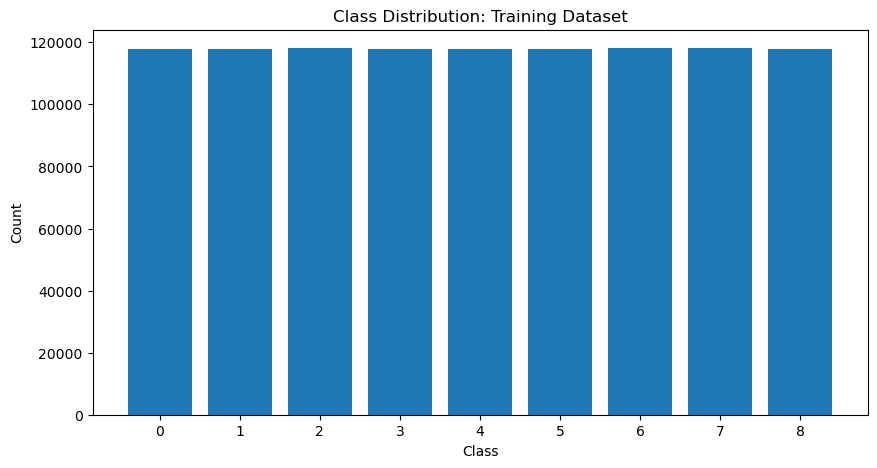

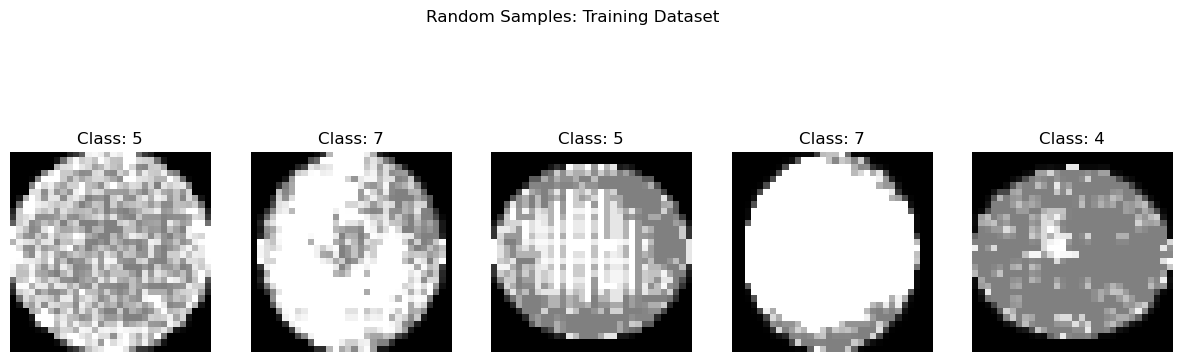

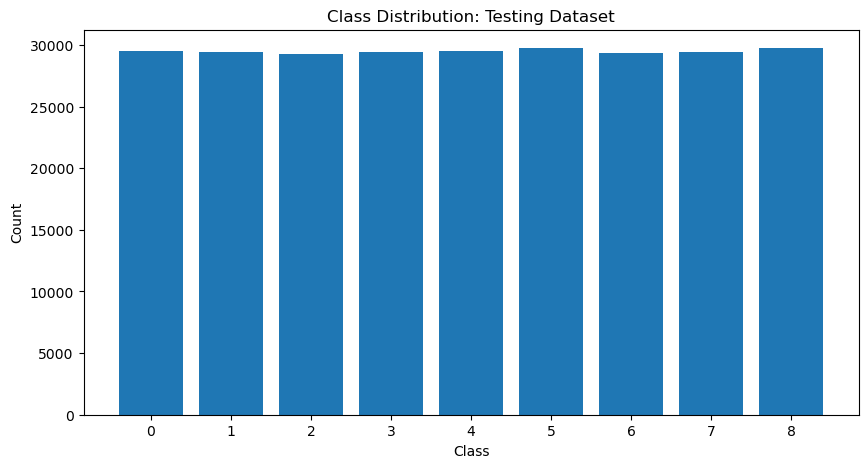

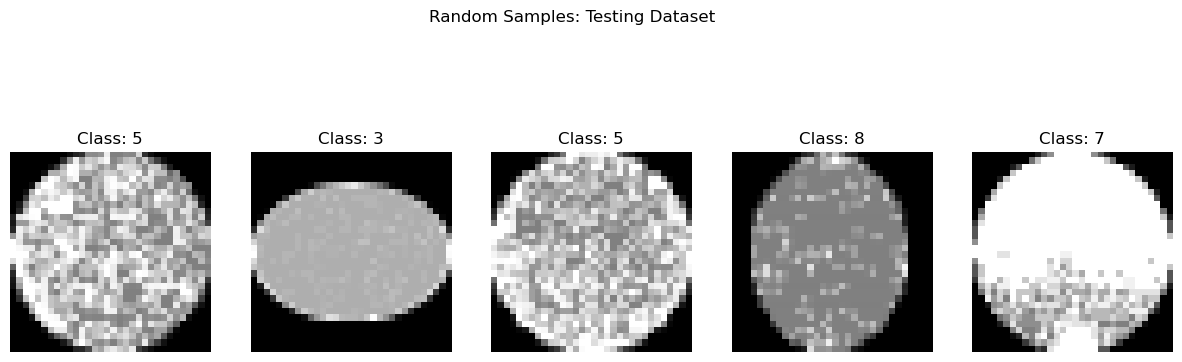

c:\Users\Soumya Taneja\myAnaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Soumya Taneja\myAnaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [10]:
cdada_model = CDADA(pkl_file_path='C:/Users/Soumya Taneja/Desktop/Sideproject/WM811Kdata/LSWMD.pkl', num_class=8)
cdada_model.train()



In [ ]:
cdada_model.plot_learning_curve()

 Save the Trained Model

In [ ]:
# Save the trained model
torch.save({
    'generator_state_dict': self.Generator.state_dict(),
    'classifier_state_dict': self.Classifier.state_dict(),
    'classifier1_state_dict': self.Classifier1.state_dict(),
    'classifier2_state_dict': self.Classifier2.state_dict()
}, 'cdada_model.pth')
print("Model saved as 'cdada_model.pth'")


Load the saved model

In [ ]:
# Initialize the model
cdada_model = CDADA(pkl_file_path='new_dataset.pkl', num_class=8)

# Load the saved model parameters
checkpoint = torch.load('cdada_model.pth')
cdada_model.Generator.load_state_dict(checkpoint['generator_state_dict'])
cdada_model.Classifier.load_state_dict(checkpoint['classifier_state_dict'])
cdada_model.Classifier1.load_state_dict(checkpoint['classifier1_state_dict'])
cdada_model.Classifier2.load_state_dict(checkpoint['classifier2_state_dict'])

print("Model parameters loaded successfully.")
